# Deep Recurrent Q-Network 

## MDP vs. POMDP
### MDP
- 전체 세계에 대한 관찰이 모두 가능함
- 각각의 프레임에서 에이전트는 보상을 최대화하기 위해 알아야 하는 모든 정보를 알 수 있음
- 즉, 에이전트가 최적으로 액션을 취하는 데 필요한 모든 정보를 제공하는 환경

### POMDP(Partially Observable Marcov Decision Process)
- 에이전트에게 제한된 방식으로 정보를 제공함
- 이런 환경에서 신경망 에이전트를 구현하기 위해선 관찰을 시간적으로 통합해야함(temporal itengration)
    - 시간의 흐름에 따라 변화하는 정보를 충분히 모으기 위해서!
        - 앞에서 배운건 예로 4개의 프레임을 버퍼에 한꺼번에 저장함.
            - 근데 이건 공간적인 부분도 크게 차지하고, 4개 훨씬 전에 프레임은 기억 못한다는 단점 => 이를 해결하기 위한 방법이 필요함 (RNN 도입)
    

## DRQN
1. 합성곱계층 출력값과 가치 및 어드밴티지 스트림 사이에 들어가는 입력값 사이에 LSTM 셀 추가
2. 경험 버퍼가 메모리 저장하는 방식 조절
    - 랜덤한 경험배치 이용 x 
    - 경험 버퍼는 전체 에피소드를 저장. 특정 길이의 경험 추이를 그릴 수 있어야함
3. DRQN을 이용해 신경망 학습
    - 모든 경사를 역전파 x, 주어진 추이에 대한 경사 마지막 1/2만 역전파로 보냄. 
    - 배치 내 추이 앞쪽 1/2 부분에 대한 비용을 마스킹 처리함으로써 간단히 구현함
    
            

In [2]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
%matplotlib inline

from helper import *

In [3]:
from gridworld import gameEnv

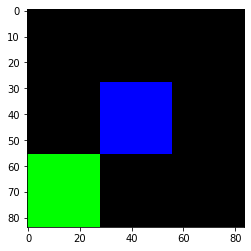

In [14]:
env = gameEnv(partial=True,size=9)

## 네트워크 만들기

In [16]:
class Qnetwork():
    def __init__(self,h_size,rnn_cell,myScope):
        # 네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다.(flattening)
        # 그 다음 배열의 크기를 재조절하고 4개의 합성곱을 거쳐 처리한다.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.convolution2d( \
            inputs=self.imageIn,num_outputs=32,\
            kernel_size=[8,8],stride=[4,4],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv1')
        self.conv2 = slim.convolution2d( \
            inputs=self.conv1,num_outputs=64,\
            kernel_size=[4,4],stride=[2,2],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv2')
        self.conv3 = slim.convolution2d( \
            inputs=self.conv2,num_outputs=64,\
            kernel_size=[3,3],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv3')
        self.conv4 = slim.convolution2d( \
            inputs=self.conv3,num_outputs=h_size,\
            kernel_size=[7,7],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv4')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        
        # 마지막 합성곱 계층에서 출력값을 취한 후 이를 순환 계층에 보낸다.
        # 입력값은 RNN 처리를 위해 [batch x trace x units] 로 크기를 바꿔야 하며
        # 상위 레벨로 전달될 때 [batch x units] 형태로 리턴해야 한다.
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
        self.convFlat = tf.reshape(slim.flatten(self.conv4),
                                   [self.batch_size,self.trainLength,h_size])
        self.state_in = rnn_cell.zero_state(self.batch_size, tf.float32)
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                inputs=self.convFlat,cell=rnn_cell,dtype=tf.float32,initial_state=self.state_in,scope=myScope+'_rnn')
        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        
        # 순환 플레이어의 출력값을 어드밴티지 스트림과 가치 스트림으로 분리한다.
        self.streamA,self.streamV = tf.split(self.rnn,2,1)
        self.AW = tf.Variable(tf.random_normal([h_size//2,4]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        self.salience = tf.gradients(self.Advantage,self.imageIn)
        
        # 최종 Q값을 얻기 위해 어드밴티지 스트림과 가치 스트림 조합함
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        # 타깃 Q값과 예측 Q값의 차의 제곱합을 구함으로써 비용을 얻는다.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,4,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        # 정확한 경사만 네트워크에 전파하기 위해
        # 각각의 추이에 대해 비용의 앞쪽 1/2를 마스크 처리함
        self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
        self.maskB = tf.ones([self.batch_size,self.trainLength//2])
        self.mask = tf.concat([self.maskA,self.maskB],1)
        self.mask = tf.reshape(self.mask,[-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        

        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

## 경험 리플레이
경험을 저장하고 네트워크를 학습하기 위해 랜덤하게 샘플링하기 위한 클래스


In [20]:
# 경험의 전체 에피소드 저장
class experience_buffer():
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
    
    # 네트워크에서 필요한 학습 배치를 얻을 수 있게 해줌
    def sample(self,batch_size,trace_length):
        sampled_episodes = random.sample(self.buffer,batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])

## 네트워크 학습

In [22]:
#Setting the training parameters
batch_size = 4 # 각 학습 단계에서 사용할 경험 배치 수
trace_length = 8 # 학습 시 각 경험 추이의 길이
update_freq = 5 # 학습 단계 업데이트 빈도
y = .99 # 타깃 Q 값에 대한 discount facotor
startE = 1 # 랜덤한 액션을 시작할 확률
endE = 0.1 # 랜덤한 액션을 끝낼 확률
anneling_steps = 10000 # startE에서 endE로 줄어드는데 필요한 학습 단계 수
num_episodes = 10000 # 네트워크를 학습시킬 에피소드의 수
pre_train_steps = 10000 # 학습 시작 전 랜덤 액션 단계 수
load_model = False # 저장된 모델을 로드할지 여부
path = "./drqn" # 모델 저장 경로
h_size = 512 # 어드밴티지/가치 스트림으로 분리되기 전 마지막 합성곱 계층 크기
max_epLength = 50 # 허용되는 최대 에피소드 길이
time_per_step = 1 # gif 생성에 사용되는 각 단계의 길이
summaryLength = 100 # 분석을 위해 주기적으로 저장할 에피소드 수
tau = 0.001 # 타깃 네트워크를 제 1 네트워크로 업데이트 하는 비율

In [ ]:
tf.reset_default_graph()
# 최초의 Q 네트워크와 타깃 Q 네트워크에 대한 셀들을 정의
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

# 랜덤 액션이 감소하는 비율을 설정
e = startE
stepDrop = (startE - endE)/anneling_steps

# 보상의 총계와 에피소드별 단계 수를 담을 리스트를 생성
jList = []
rList = []
total_steps = 0

# 모델을 저장할 경로 설정
if not os.path.exists(path):
    os.makedirs(path)

##Write the first line of the master log-file for the Control Center
# with open('./Center/log.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
  

with tf.Session() as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    sess.run(init)
   
    # 타깃 네트워크가 제 1 네트워크와 동일하도록 설정
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = []
        
        # 환경을 리셋하고 첫번째 새로운 관찰을 얻는다.
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        # 순환 계층의 은닉 상태를 리턴한다.
        state = (np.zeros([1,h_size]),np.zeros([1,h_size])) #Reset the recurrent layer's hidden state

        # Q 네트워크
        while j < max_epLength: 
            j+=1
            
            # Q 네트워크에서 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션 선택
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                # 랜덤 액션 선택
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                # 그리디하게 액션 선택
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
                
            s1P,r,d = env.step(a) # 보상 받음
            s1 = processState(s1P) # next state
            total_steps += 1
            # 에피소드 버퍼에 추가
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    updateTarget(targetOps,sess)

                    # 순환 계층의 은닉 상태를 리셋함
                    state_train = (np.zeros([batch_size,h_size]),np.zeros([batch_size,h_size])) 
                    
                    # 경험에서 랜덤하게 배치 하나를 샘플링
                    trainBatch = myBuffer.sample(batch_size,trace_length) #Get a random batch of experiences.
                    
                    # 타깃 Q값에 대해 더블 DQN 업데이트를 수행
                    Q1 = sess.run(mainQN.predict,feed_dict={\
                        mainQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
                    Q2 = sess.run(targetQN.Qout,feed_dict={\
                        targetQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
                    
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size*trace_length),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    
                    # 타깃값을 이용해 네트워크 업데이트
                    sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]/255.0),mainQN.targetQ:targetQ,\
                        mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                        mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        # 에피소드를 경험 버퍼에 추가해준다.
        bufferArray = np.array(episodeBuffer)
        episodeBuffer = list(zip(bufferArray))
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        # 주기적으로 모델을 저장한다. 
        if i % 1000 == 0 and i != 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print ("Saved Model")
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
#             saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
#                 summaryLength,h_size,sess,mainQN,time_per_step)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')

Target Set Success


/Users/ohyeji/anaconda3/envs/tf1/lib/python3.6/site-packages/ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


5000 0.43 1
10000 0.45 1
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
90000 4.29 0.09999999999985551
Target Set Success
Target Set Success


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
105000 4.67 0.09999999999985551
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
120000 5.28 0.09999999999985551
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

## 네트워크 테스트

In [ ]:
e = 0.01 #The chance of chosing a random action
num_episodes = 10000 #How many episodes of game environment to train network with.
load_model = True #Whether to load a saved model.
path = "./drqn" #The path to save/load our model to/from.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
max_epLength = 50 #The max allowed length of our episode.
time_per_step = 1 #Length of each step used in gif creation
summaryLength = 100 #Number of epidoes to periodically save for analysis

In [ ]:
tf.reset_default_graph()
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

# ##Write the first line of the master log-file for the Control Center
# with open('./Center/log.csv', 'w') as myfile:
#     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#     wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
    
    #wr = csv.writer(open('./Center/log.csv', 'a'), quoting=csv.QUOTE_ALL)
with tf.Session() as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(init)

        
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]),np.zeros([1,h_size]))
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,\
                    mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        bufferArray = np.array(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        #Periodically save the model. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
#             saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
#                 summaryLength,h_size,sess,mainQN,time_per_step)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")